# 🤖 BERT Fine-Tuning for Sentiment Classification

In this project you will revisit the sentiment classification task that we did in Assignment 1. However, instead of a BOW classifier, you will build a neural network classifier by fine-tuning a pretrained language model. This approach to building classifiers is the current state-of-the-art, so learning how to do this should set you up very well for many future NLP problems you may want to tackle!

The main learning objectives for this assignment are:
1. Understand how to design a basic experimental loop in PyTorch (loading data, training, and evaluating a model)
2. Learn how to navigate and follow online documentation for PyTorch and HuggingFace.
3. Observe the effect of pretraining on model performance, and understand how "fine-tuning" differs from traditional model training.

**Note**: An important goal of this assignment is to teach you how to use online documentation. The world of deep learning libraries and codebases --specifically for NLP-- is rapidly evolving as interest in the field is growing and researchers increasingly opensource their code. As a result, a critical skill of successful NLP researchers and engineers is the ability to learn how to write code on one's own by reading documentation and looking at examples. [PyTorch](https://pytorch.org/docs/stable/index.html) and [Hugging Face](https://huggingface.co/docs) have great documentation. You may use whatever documentation you'd like, however you **cannot ask questions on Stack Overflow or any platform except for those specifically created by the course staff (e.g. Edstem)**.

We require you to implement the training and testing loops from native PyTorch, **you may not use the Hugging Face Trainer API**. However, in reality, one would use the Trainer API - [here](https://huggingface.co/docs/transformers/main_classes/trainer) is the documentation for it.

### ❗ **Remember to copy this notebook** ❗

## Imports and package installation

These are all of the packages available for use during this assignment, they're all you should need. They must first be installed on this runtime, and then imported.

In [ ]:
!pip install transformers torch datasets tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.6 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch, codecs, random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import datasets
from datasets import load_metric
from google.colab import output
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Any
from transformers import PreTrainedTokenizer
from torch.optim import Optimizer

output.enable_custom_widget_manager()

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


If the following fails, your current Colab runtime doesn't have a GPU :( . To fix this, simply select 'Runtime' -> 'Change runtime type', then select 'GPU' under 'Hardware accelerator' and then press save.

In [ ]:
assert torch.cuda.is_available()

## Part 1 - Baseline model


### 1. Dataset loading:

We need to load the dataset. For this assignment, [the same dataset as in assignment 1](https://drive.google.com/file/d/1AF2v6Cu_gNTe7lzpz_4zsMWMgJ-XjuSh/view?usp=sharing) is used. You can do this by uploading the dataset to this runtime:

1. Click on the 'Files' tab of the left sidebar
2. Click on the 'Upload' button that should now be exposed, and select the dataset from wherever you downloaded it
3. Change the line `read_csv(FILEPATH, ...)` to `read_csv("Tweets_5K.csv", ...)`

However, you will have to reupload the file every time your runtime changes. You can also just update the `FOLDER` variable we have given you to redirect to where you have the data stored in your Drive (perhaps the same `FILEPATH` as assignment 1!).

The dataset contains a total of 5,000 labeled examples, the first 3,000 of which may be used in training. The next 1,000 can be used as a validation set, and the final 1,000 should be used for testing. The `'text'` column contains a raw Tweet, and the `'sentiment'` column contains the label (`'negative'`, `'neutral'`, or `'positive'`).

In [ ]:
import pandas as pd

# Change this folder if you've placed the .csv elsewhere in your drive.
FOLDER = "/content/drive/My Drive/CSCI 1460 Colab Notebooks"  # Extend this string to point to the directory with your copy of Tweets_5K.csv
# FILEPATH = f"{FOLDER}/Tweets_5K.csv"
FILEPATH = f"Tweets_5K.csv"

dataset = pd.read_csv(FILEPATH, header=0, sep=',')

# X should be raw tweet text, y should be integer labels from the sentiment column ('negative': 0, 'neutral': 1, 'positive': 2)
# X: List<String>
# y: List<int> (can be list-like)
X = dataset['text'].tolist()
y = dataset['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}).tolist()

# split X and y into a train/validation/test set, use fixed-indices (3000/1000/1000)
trainset, trainlabs = X[:3000], y[:3000]
valset, vallabs = X[3000:4000], y[3000:4000]
testset, testlabs = X[4000:], y[4000:]

Next, we need to define a child class to the Pytorch `Dataset` class, such that we can customize it for our specific dataset, and also configure the tokenizer (which we'll initialize in a moment). The `__getitem__` function is what will be used to fetch all training examples by the eventual dataloader. `__getitem__` needs to tokenize the input tweets in the BERT fashion ([CLS] and [SEP] tokens need to be inserted as discussed in lecture, etc.)

This has been written for you.

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
  """
  A PyTorch Dataset for our tweets that can be iterated through using __getitem__
  """
  def __init__(self, tweets : List[str], sentiments : List[int], tokenizer : PreTrainedTokenizer) -> None:
    """
    Initializes the TweetDataset from a list of tweets, their corresponding sentiments, and a tokenizer.

    Attributes
    ----------
    tweets : List[str]
      A list of tweets, where each tweet is a string
    sentiments: List[int]
      A list of sentiments represented as integers ('negative': 0, 'neutral': 1, 'positive': 2)
    tokenizer : PreTrainedTokenizer
      Any PreTrainedTokenizer from HuggingFace can be used to encode the string inputs for a model
    """
    self.tweets = tweets
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = tokenizer.model_max_length

  def __len__(self) -> int:
    """
    Returns the number of tweets in the dataset.
    """
    return len(self.tweets)

  def __getitem__(self, index : int) -> Dict[str, Any]:
    """
    Retrieve a preprocessed data item from the dataset at the specified index.
    This is called when iterating through a TweetDataset

    Parameters:
    ----------
    index : int
        The index of the data item to retrieve.

    Returns:
    -------
    Dict[str, Any]
        A dictionary containing the preprocessed data for the given index.
        The dictionary includes the following keys:
        - 'input_ids': Encoded input IDs for the tweet.
        - 'attention_mask': Attention mask for the tweet.
        - 'labels': Sentiment label as a PyTorch tensor.
    """
    tweet = str(self.tweets[index])
    sentiments = self.sentiments[index]

    encoded_tweet = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens      = True,
      max_length              = self.max_len,
      return_token_type_ids   = False,
      return_attention_mask   = True,
      return_tensors          = "pt",
      padding                 = "max_length",
      truncation              = True
    )

    return {
      'input_ids': encoded_tweet['input_ids'][0],
      'attention_mask': encoded_tweet['attention_mask'][0],
      'labels': torch.tensor(sentiments, dtype=torch.long)
    }

### 2. Tokenizer and dataloader:


Now that we have the `TweetDataset` class, you must construct the appropriate instances for our training, validation, and testing sets. Afterwhich, they must be used to construct PyTorch `DataLoader` instances (refer to PyTorch [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)).

At this point, batch sizes will have to be specified. This may require some experimentation, as the larger the batch size, the faster the models will train, however they will also use more VMEM (Video Memory, like RAM, but on a GPU). If you get an error during training or testing about running out of memory, reduce your batch sizes here.

Finally, we'll load the distilbert-base-uncased tokenizer from Hugging Face, the tokenizer that will be applied to the tweet text.

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# use this for the tokenizer argument of the TweetDataset
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# define the following TweetDataset objects... be careful to split the data as previously specified
train_dataset = TweetDataset(trainset, trainlabs, tokenizer)
validation_dataset = TweetDataset(valset, vallabs, tokenizer)
test_dataset = TweetDataset(testset, testlabs, tokenizer)

# now construct DataLoader objects from the TweetDataset objects
# Define batch sizes
batch_size = 8
# remember that the TweetDataset class is a child class of torch.utils.data.Dataset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 3. Loading model:

Here we use the Hugging Face transformers library to load the architecture of the distilbert-base-uncased model. This model (DistilBERT) is usually trained for a masked language modeling, you can read more about it [here](https://huggingface.co/distilbert-base-uncased). It's basically a smaller version of BERT, which was covered in lecture (it's been '[distilled](https://arxiv.org/abs/1910.01108)').

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification

# getting the distilbert-base-uncased config...
config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=3)
# ...from which we can use AutoModelForSequenceClassification to instantiate
# an UNTRAINED version of the above model, read Hugging Face documentation
# to figure out how to do so!
untrained_model = AutoModelForSequenceClassification.from_config(config)

### 4. Evaluation loop:

We need to define an evaluation function, such that we can measure a model's performance on a dataset.

For evaluation, there are a couple of steps that must be taken. For each batch in the evaluation set:
1. Apply the model on the batch (feedforward)
2. Obtain the predictions from the model output
3. Update the metrics and progress bar

Hugging Face documentation is your friend - the function signature is also provided.

**A note on logits**: Logits are unnormalized predictions of a model. In this case, we have three classes: negative, neutral, or positive. One can assign a single output at the end of a model to each of these classes. For our purposes we can take the prediction of the model to be the class with the maximum of these three values (take the argmax across the outputs), but we could additionally determine the model's confidence in the input belonging to each class by applying a normalizing function to the logits, one such function is softmax (no need to do this here)! The argmax of the logits is our prediction, which can be compared to the label. This may be useful when tracking metrics. This is important here since DistilBERT's classifier outputs logits...

**A note on PyTorch devices**

In PyTorch, tensor operations can be performed on devices, usually CPUs and GPUs. Tensors can be set to certain devices to optimize operations through parallelization. The operation to set a tensor to a device can be seen [here](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html). Note that the returned tensor is now a copy if the device is changed. **Hint**: Setting a tensor to the correct device is necessary when using them for a model on the GPU!

In the code below, the model's parameters are loaded onto the device we are using. This gives us a way to use the GPU to run models by putting all of its parameters and computations on it!



In [ ]:
# For any parameter named 'device', pass the following variable:
device = torch.device("cuda")

# Loading the model onto the device
untrained_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
def update_metrics(metrics: List[datasets.Metric], predictions: torch.Tensor, labels: torch.Tensor) -> None:
  """
  Update a list of metrics with new predictions and labels

  Parameters:
  -----------
  metrics : List[Metric]
      List of metrics.
  predictions : torch.Tensor
      Tensor of predictions of shape (batch_size, ...)
  labels : torch.Tensor
      Tensor of labels of shape (batch_size, ...)

  Returns:
  --------
  None
  """
  # Nothing TODO here! This updates metrics based on a batch of predictions
  # and a batch of labels.
  for metric in metrics:
    metric.add_batch(predictions=predictions, references=labels)

def evaluate(model: torch.nn.Module, test_dataloader: torch.utils.data.DataLoader,
             device: torch.device, metric_strs: List[str]) -> Dict[str, float]:
  """
  Evaluate a PyTorch Model

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be evaluated.
  test_dataloader : torch.utils.data.DataLoader
      DataLoader containing testing examples.
  device : torch.device
      The device that the evaluation will be performed on.
  metric_strs : List[str]
      The names of Hugging Face metrics to use.

  Returns:
  --------
  Dict[str, float]
      Dictionary of metric names mapped to their values.
  """
  # load metrics
  metrics = [load_metric(x) for x in metric_strs] # could add more here!
  model.eval()

  # we like progress bars :)
  progress_bar = tqdm(range(len(test_dataloader)))
  # HINT: progress_bar.update(1) should be used to show progress after an iteration

  # TODO: Fill in the evaluate function by applying the model with the dataloader
  for batch in test_dataloader:
      # print(batch)
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device) # should not provide the labels

      with torch.no_grad():
          # Forward pass
          outputs = model(input_ids, attention_mask=attention_mask, labels=labels) #??labels??

          # Get predicted labels
          pred_index = torch.argmax(outputs.logits, dim=1)

          # Update metrics
          update_metrics(metrics, pred_index, labels)

      # Update progress bar
      # progress_bar.update(1)
      torch.cuda.empty_cache()
      progress_bar.update(1)
      del input_ids, attention_mask, labels


  ###########################################################################
  # compute and return metrics
  computed = {}
  for m in metrics:
    computed = {**computed, **m.compute()}

  return computed

### 5. Baseline performance:

*Warning: Be aware that since this is a Jupyter Notebook, sometimes it is necessary to re-execute the cell defining the models in order to restart training from scratch. Also, sometimes 'CUDA out of memory' errors are due to past models residing on the GPU, the easiest way to fix this is to restart the Colab runtime (CTRL + M + .), or to run a cell that deletes models (`del <model>`). A batch size of 32 for training should be small enough such that models train without memory issues. To change the batch size, modify the `batch_size` parameter passed when initializing the `DataLoader`.*

Now that we have an untrained model, our dataset, and an evalutation function, we can evaluate the to find our baseline accuracies!

The next cell contains some code to make nice accuracy plots.

In [ ]:
from scipy.stats import describe
from math import sqrt

def make_plots(perfs: List[float], names: List[str]) -> None:
  """
  Create bar plots for performance metrics.

  Parameters:
  -----------
  perfs : List[float]
      List of performance values (e.g., accuracies).
  names : List[str]
      List of names for the corresponding performance metrics.
  """
  # Nothing TODO here
  for perf, name in zip(perfs, names):
    print(f"{name} accuracy: {perf}")
  plt.bar(np.arange(len(perfs)), perfs)
  plt.xticks(np.arange(len(names)), names)
  plt.show()

Now, let's execute our evaluation loop on the testing set. In terms of metrics, we'll only keep track of accuracy for now, however you can add others to the metric list (check the Hugging Face datasets documentation).


We should see that the baseline (expectedly) performs poorly.

  0%|          | 0/125 [00:00<?, ?it/s]

Baseline accuracy: 0.33


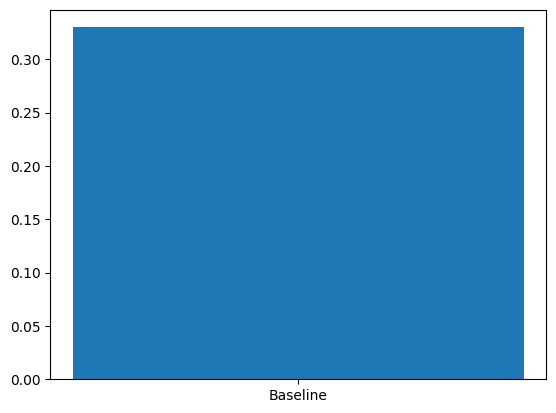

In [ ]:
metrics = ['accuracy']
# TODO: evaluate on the test dataset
baseline_result = evaluate(untrained_model, test_dataloader, device, metrics)['accuracy']

# now, plot! Do not modify the following:
results = [baseline_result]
names = ['Baseline']
make_plots(results, names)

## Part 2 - Model trained from scatch




### 1. Defining the training loop:

The training loop follows similar steps to the evaluation loop:
For each batch in each epoch:
1. Apply the model on the batch inputs (feedforward)
2. Obtain the predictions, as well as the labels
3. Compare the predictions with the labels and calculate the loss
4. Backpropagate the loss and obtain gradients for all parameters
5. Update the optimizer and learning rate
6. Record the desired metrics based on the outputs and labels
In addition to this, we'd like to keep track of some metrics during each epoch, and at the end of an epoch we want to run an evaluation on the validation set (you can use the evaluation loop!). Specifically, we want to know the training accuracy (accuracy measured against the training set) and validation accuracy - they can be reported through `print` statements.

Reading [PyTorch](https://pytorch.org/docs/stable/index.html) documentation should be very useful here. We'll provide the function signature.

In [ ]:
def train(model: torch.nn.Module, optimizer: Optimizer, num_epochs: int,
          train_dataloader: DataLoader, validation_dataloader: DataLoader,
          lr_scheduler: Any, device: torch.device) -> None:
  """
  Trains a model by performing a forward pass and backpropating on batches to optimize loss.

  Parameters:
  -----------
  model : torch.nn.Module
      The model to be trained.
  optimizer : torch.optim.Optimizer
      The training optimizer.
  num_epochs : int
      Number of epochs to train for.
  train_dataloader : DataLoader
      DataLoader containing training examples.
  validation_dataloader : DataLoader
      DataLoader containing validation examples.
  lr_scheduler : Any
      Learning rate scheduler.
  device : torch.device
      The device that the training will be performed on.

  Returns:
  --------
  None
  """

  for epoch in range(num_epochs):
    # put the model in training mode (important that this is done each epoch,
    # since we put the model into eval mode during validation)
    model.train()

    # load metrics
    metrics = [load_metric(x) for x in ["accuracy"]] # could add more here!

    print(f"Epoch {epoch + 1} training:")
    progress_bar = tqdm(range(len(train_dataloader)))

    # TODO: Fill in the rest of the train function by applying the model with the dataloader
    for batch in train_dataloader: # Apply the model on the batch inputs (feedforward)
        # Move data to the specified device
        # print(batch)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels) # also feed in the labels
        # print(outputs)
        loss = outputs.loss

        # Get predicted labels
        # what to use argmax to find the corresponding prob that gives the highest predict
        pred_index = torch.argmax(outputs.logits, dim=1) # Obtain the predictions, as well as the labels

        # Calculate loss
        # loss = torch.nn.CrossEntropyLoss(preds, labels) # Compare the predictions with the labels and calculate the loss

        # Backpropagation and optimization
        loss.backward() # Backpropagate the loss and obtain gradients for all parameters
        optimizer.step() # Update the optimizer
        lr_scheduler.step() # Update the learning rate

        # Update metrics
        update_metrics(metrics, pred_index, labels)
        progress_bar.update(1)

    #######################################################################

    # print the epoch's average metrics
    print(f"Epoch {epoch+1} average training metrics: accuracy={metrics[0].compute()['accuracy']}")

    # normally, validation would be more useful when training for many epochs
    print("Running validation:")
    # TODO: evaluate model on validation dataset
    # val_metrics = evaluate(...)
    val_metrics = evaluate(model, validation_dataloader, device, metric_strs=["accuracy"])
    print(f"Epoch {epoch+1} validation: accuracy={val_metrics['accuracy']}")


### 2. Training the untrained model:

Great - now that we've define our training function, we can use it to try to train the untrained model from scratch! Train the model for **2 epochs**!

**A note on warmup steps, optimizers**: Optimizers like AdamW try to adapt the learning rate for individual parameters by collecting statistics about them. Warmup impacts some optimizers. Warmup steps allow the statistics calculated by some optimizers to converge before the optimizer starts to update parameters impactfully. During the warmup, the optimizer is updating parameters, but just by a much smaller magnitude than usual. Read more about optimizers [here](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/#:~:text=While%20training%20the%20deep%20learning,loss%20and%20improve%20the%20accuracy.), and warmup [here](https://d2l.ai/chapter_optimization/lr-scheduler.html#warmup). The warmup is handled by the learning rate scheduler behind the scenes.

First, we need to set up our optimizer, learning rate scheduler, and determine the number of epochs to train for. These are all parameters to the `train` function.

In [ ]:
from transformers import get_scheduler

num_epochs = 2

# TODO: use the AdamW optimizer. Use torch.optim.AdamW.
# instantiate it on the untrained model parameters with a learning rate of 5e-5
# optimizer = ...
optimizer = torch.optim.AdamW(untrained_model.parameters(), lr=5e-5)

# now, we set up the learning rate scheduler
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

In [ ]:
torch.cuda.empty_cache()
untrained_model.to(device)

# TODO: now call your training loop!
# train(...)
train(untrained_model, optimizer, num_epochs, train_dataloader, validation_dataloader, lr_scheduler, device)

Epoch 1 training:


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.39966666666666667
Running validation:


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.511
Epoch 2 training:


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.626
Running validation:


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.604


Hypothetically, the untrained model is now slightly trained - yet based on the validation scores, things didn't go that well.

### 3. Evaluate the trained model:

Call the evaluation loop on the model we just trained! View the bar graph to compare it to the baseline.

  0%|          | 0/125 [00:00<?, ?it/s]

Baseline accuracy: 0.33
Manually Trained accuracy: 0.599


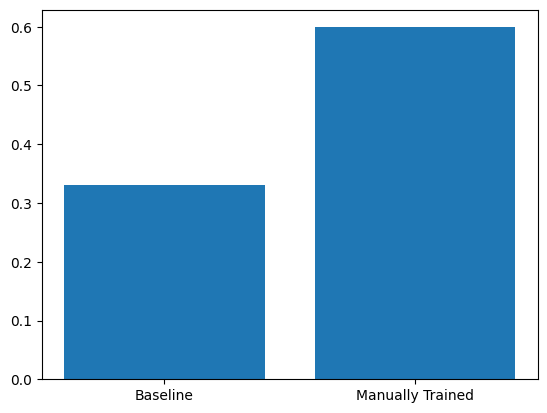

In [ ]:
metrics = ['accuracy']

# TODO: Evaluate on test dataset!
# trained_result = evaluate(...)['accuracy']
trained_result = evaluate(untrained_model, test_dataloader, device, metric_strs=metrics)['accuracy']

# now, plot! Do not modify the following:
results = baseline_result, trained_result
names = ['Baseline', 'Manually Trained']
make_plots(results, names)

As you can see, this model achieves an accuracy of around 55% after the first two epochs. Training it for further epochs (which you don't need to do) renders minimal improvement. To achieve better performance when training DistilBERT from scratch for this purpose, we'd need a lot more data and a lot more time (and/or compute). Fortunately, there is a better way!

## Part 3 - Finetuning a pre-trained model

Since manually training the model didn't work very well, let's fine-tune a pre-trained model.

### 1. Load pre-trained model:

This time, we'll make use of a pre-trained version of DistilBERT - everything's the same as before, but the model has actually been trained for a language modeling task.

In [ ]:
from transformers import DistilBertForSequenceClassification

# TODO: load the distilbert-base-uncased pre-trained model, use DistilBertForSequenceClassification
# from Hugging Face (transformers), read their documentation to do this.
# WARNING: This dataset has three classes! The default for this model is two!
# pretrained_model = ...
pretrained_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Ignore the warnings printed below.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's give it a test run...
To motivate, the pre-trained model isn't particularly good at this specific task out-of-the box, to see this, evaluate it on the test set just the way it is.

  0%|          | 0/125 [00:00<?, ?it/s]

Baseline accuracy: 0.33
Manually trained accuracy: 0.599
Pre-trained accuracy: 0.35


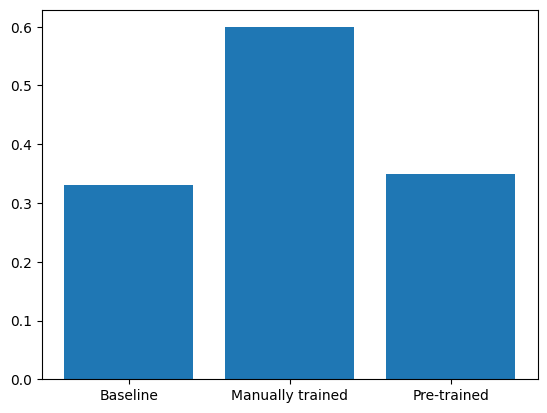

In [ ]:
# We have to move it to the device before doing anything with it!
pretrained_model.to(device)

# TODO: call evaluate on the pre-trained model!
pretrained_result = evaluate(pretrained_model, test_dataloader, device, metric_strs=metrics)['accuracy']

# now, plot! Do not modify the following:
results = [baseline_result, trained_result, pretrained_result]
names = ['Baseline', 'Manually trained', 'Pre-trained']
make_plots(results, names)

As we can see, without any fine-tuning, the pre-trained model performs rather badly. This makes sense, since DistilBERT is pre-trained on a masked language modelling task, so the classifier portion of DistilBERT isn't at all trained for sentiment classification (recall architecture and training of BERT from lecture).

### 2. Fine-tuning pre-trained model:

Rather than train the model from scratch, we'll now fine-tune the pre-trained model!
We'll fine-tune by simply running the `train` function on our pre-trained model with the training data! Fine-tune it for **2 epochs**.

In [ ]:
num_epochs = 2

# TODO: use the same kind of optimizer as before, but with the pretrained model's parameters
# optimizer = ...
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=5e-5)

# this hasn't changed
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

In [ ]:
torch.cuda.empty_cache()
pretrained_model.to(device)

# TODO: train!
# train(...)
train(pretrained_model, optimizer, num_epochs, train_dataloader, validation_dataloader, lr_scheduler, device)

Epoch 1 training:


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.6663333333333333
Running validation:


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.725
Epoch 2 training:


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.8373333333333334
Running validation:


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.756


You should've seen a sneak-peak of the model's performance based on the validation accuracies!

### 3. Evaluating the fine-tuned model:

  0%|          | 0/125 [00:00<?, ?it/s]

Baseline accuracy: 0.33
Manually trained accuracy: 0.599
Pre-trained accuracy: 0.35
Fine-tuned accuracy: 0.755


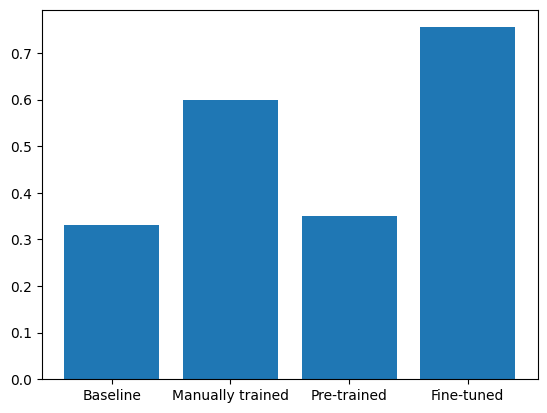

In [ ]:
# TODO: Evaluate the fine-tuned model on the test dataset
# finetuned_result = evaluate(...)['accuracy']
finetuned_result = evaluate(pretrained_model, test_dataloader, device, metric_strs=metrics)['accuracy']

# now, plot! Do not modify the following:
results = [baseline_result, trained_result, pretrained_result, finetuned_result]
names = ['Baseline', 'Manually trained', 'Pre-trained', 'Fine-tuned']
make_plots(results, names)

Wow! With just two epochs of training, and only 3k training examples, we can achieve ~75% accuracy (this should be attainable)! As we can see, the pre-trained model has a very noticeable advantage over the completely untrained one. Training for an additional epoch renders a slight improvement, afterwhich the fine-tuning begins to overfit on our training set, which can be judged by comparing the average epoch training accuracies and validation accuracies.

Additionally, remember that this was the dataset used in assignment 1, where you had to do significant pre-processing to get the accuracy to just ~65%! With ease (and less training data, since here we had a 60/20/20 split), DistilBERT has an even better performance (take it with a grain of salt, however, since we didn't do cross-validation).

## Part 4 - Frozen pre-trained representations

Another way to fine-tune a model is to transfer 'frozen' representations with a new network. When freezing layers of a model, the weights of those layers are no longer able to update when backpropagating. Refer to the lecture on fine-tuning and frozen representations for a more detailed introduction.

We will train a pre-trained model while freezing the weights of the embeddings and first two Transformer layers. Feel free to adapt your code from Part 3 for all of the corresponding TODO's.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


distilbert DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
         

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1 average training metrics: accuracy=0.662
Running validation:


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 validation: accuracy=0.75
Epoch 2 training:


  0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2 average training metrics: accuracy=0.821
Running validation:


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 validation: accuracy=0.748


  0%|          | 0/125 [00:00<?, ?it/s]

Baseline accuracy: 0.33
Manually trained accuracy: 0.599
Pre-trained accuracy: 0.35
Fine-tuned accuracy: 0.755
Frozen accuracy: 0.739


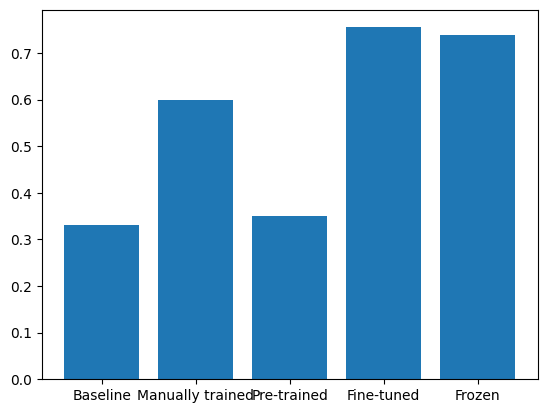

In [ ]:
#@title
from transformers import DistilBertForSequenceClassification

# TODO: Again, load the distilbert-base-uncased pre-trained model, use DistilBertForSequenceClassification
# from Hugging Face (transformers), read their documentation to do this.
# WARNING: This dataset has three classes! The default for this model is two!
# frozen_model = ...
frozen_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# The line of code below may be useful for understanding which parts of the model should be frozen
for name, module in frozen_model.named_children():
  print(name, module)

# TODO: Freeze the embeddings module and first two transformer layers of the model
for name, param in frozen_model.named_parameters():
    if 'embeddings' in name or 'layer.0' in name or 'layer.1' in name:
        param.requires_grad = False

frozen_model.to(device)
num_epochs = 2

# TODO: use the same kind of optimizer as before, but only pass in parameters that are not frozen
optimizer = torch.optim.AdamW([param for param in frozen_model.parameters() if param.requires_grad], lr=5e-5)
lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
)

torch.cuda.empty_cache()
frozen_model.to(device)
# TODO: train!
train(frozen_model, optimizer, num_epochs, train_dataloader, validation_dataloader, lr_scheduler, device)

# TODO: Evaluate the frozen model on the test dataset
frozen_result = evaluate(frozen_model, test_dataloader, device, metric_strs=metrics)['accuracy']

# now, plot! Do not modify the following:
results = [baseline_result, trained_result, pretrained_result, finetuned_result, frozen_result]
names = ['Baseline', 'Manually trained', 'Pre-trained', 'Fine-tuned', 'Frozen']
make_plots(results, names)

## Part 5 - Conceptual Questions

1. Why might the frozen model be performing with a very similar accuracy to the fine-tuned model? Consider which parts of the model we chose to freeze.

The frozen model's performance closely matching the fine-tuned model can be attributed to the specific layers chosen to be frozen. In this case, the freezing model retains the weights of the pre-trained model for embedding and the first two transformed layers, while only training the weights of the last layer, which is the classification layer. This design choice results in a situation where the majority of the model's parameters remain the same as the pre-trained model, and only a small portion is adapted to the specific classification task. So it is not surprising that the accuracy of the freezing model is very close to that of the fine-tuning model.

2. Why might we prefer to use a frozen model as opposed to a fully fine-tuned model? Use quantitative observations from the training of your frozen model vs. your fully fine-tuned model as evidence in your answer.

We might prefer to use a frozen model as opposed to a fully fine-tuned model because the frozen model is much faster to train. Also fine-tuning a large neural network with many parameters can be computationally expensive and resource-intensive. Frozen models require fewer resources as they involve fewer training iterations and less data to update.

3. In this assignment we've covered several methods of getting a language model to do a task: (i) Using a pretrained model off-the-shelf; (ii) Manually training a model from scratch; (iii) Fine-tuning a pretrained model; and (iv) Fine-tuning a partly frozen pretrained model. Organizations must balance various factors when considering which method to adopt in deploying language models. List at least two factors that an organization should consider and their implications for which method(s) would be best.

Training Time:
The amount of time it takes to train a model is a significant consideration. Training a language model from scratch or fine-tuning a model typically requires a substantial amount of time and computational resources. On the other hand, using a pretrained model off-the-shelf or fine-tuning a partly frozen pretrained model is generally much faster.


Resource Availability:
Organizations need to assess their available computational resources. Training a model from scratch or fine-tuning a large model can be computationally intensive. Pretrained models or partly frozen pretrained models are more resource-efficient.


Data Availability:
The quantity and quality of data available for training the model are important. Training from scratch or fine-tuning with limited or low-quality data may lead to poor performance and overfitting. If labeled data is limited, using a pretrained model or fine-tuning a partly frozen pretrained model can leverage the existing knowledge from a broader dataset, requiring less task-specific data.

## Hand-in:
To hand-in, first delete any debugging print statements, this helps us read your code.

Then, go to Runtime->Restart and run all to run the entire notebook with your completed code.

Finally, submit TWO files:
(1) download the notebook as a .ipynb, and
(2) go to File > Print > Save as PDF.

Upload the **.ipynb AND .pdf** to the Gradescope assignment.
